In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from numpy import linalg
from scipy import stats
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import random
from math import log2

# rip out the CV!!

def lr_classifier(X,y, SEED):
#     clf = RandomForestClassifier(max_depth=2, random_state=0)
#     clf.fit(X, y)
    #print(SEED)
    clf = LogisticRegression(solver="liblinear", random_state=SEED)
    clf.fit(X, y)
    return clf

def partition_data(data, indices):
    X, y = [], []
    for index in indices:
        X.append(data[index, :-1])
        y.append(data[index, -1])
    return np.array(X), np.array(y)

# find the pseudocode in the notes
def uncertainty_sampling(clf, data):
    # least certain is easiest
    # I assume --shape = n*2
    print (clf.predict_proba(data))
    return data[np.argmax(1- np.max(clf.predict_proba(data), axis=1))]


def mellow_uncertainty_sampling(clf, data):
    # least certain is easiest
    # I assume --shape = n*2
    poss_x = (1- np.max(clf.predict_proba(data), axis=1))
    choose_from = []
    threshold = np.mean(poss_x)
    for i in range(len(poss_x)):
        if poss_x[i] > threshold:
            choose_from.append(i)
    # randomly choose x with val above threshold
    return data[random.choice(choose_from)]


def utility(clf, x):
    # the np.min is equiv to 1 - np.max
    return (np.min(clf.predict_proba([x])[0]))
    
    
def inv_dist(x, y):
    dist = np.linalg.norm(x-y)
    # if 0 then it's the same point, no similarity bcuz we shouldn't count it
    if (dist) == 0:
        return 0
    else: 
        return 1/dist
def density_sampling(clf, data):
    # we'll say beta = 1
    # argmax is wrt  x
    # if beta =1, then (1/data.shape[0]) is just some scalar and does not influence the argmax, don't need it
    return(data[np.argmax([utility(clf, data[x,:])*np.sum([inv_dist(data[x,:],data[y,:]) for y in range(data.shape[0])]) for x in range(data.shape[0])])])
    #return np.argmax([utility(clf, [data[x,:]])*(1/data.shape[0])*(np.sum([dist(data[x,:],data[y,:]) for y in range(data.shape[0])]) for x in range(data.shape[0])])
    #np.argmax(utility(x)(1/data_Size)^{beta}(\sum{x in data} dist(x, x')^{beta}))


    
def qbc(clf, X, y, data):
    # add bagging
    clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=10, random_state=0)
    clf.fit(X, y)
    # if |score| is low then close to dec boundary, uncertain
    # checked with Kangas, this checks out
    return data[(np.argmin(abs(clf.decision_function(data))))]

def model_change(clf, X, y, data_X,):
    # X, y are prev
    # data_X are possible new points
    all_x_gradients = []
    poss_y = [0, 1]
    #https://stats.stackexchange.com/questions/219241/gradient-for-logistic-loss-function
    for x in data_X:
        p = clf.predict_proba([x])[0]
        p1 = 1/ (1+np.e**(-np.dot(clf.coef_,x.T)))
        grad1 = p1 - 0
        grad2 = p1 - 1
        x_grad = p[0]*linalg.norm(grad1) + p[1]*linalg.norm(grad2)
        all_x_gradients.append(x_grad)

    return data_X[np.argmax(all_x_gradients)]
    
def update_indices(indices, remaining_indices, dataset, clf, TYPE):
    # need to apply the remaining_indices to the data
    data_X, data_y = partition_data(dataset, remaining_indices)
    if TYPE == "random":
        next_index = random.choice(remaining_indices)
    elif TYPE == "uncertainty":
        next_datapoint = uncertainty_sampling(clf, data_X)
        next_index = np.where(dataset[:, :-1]==next_datapoint)[0][0]
    elif TYPE == "density":
        next_datapoint = density_sampling(clf, data_X)
        next_index = np.where(dataset[:, :-1]==next_datapoint)[0][0]
    elif TYPE == "qbc":
        X, y = partition_data(dataset, indices)
        next_datapoint = qbc(clf, X, y, data_X)
        next_index = np.where(dataset[:, :-1]==next_datapoint)[0][0]
    elif TYPE == "model change":
        X, y = partition_data(dataset, indices)
        next_datapoint = model_change(clf, X, y, data_X)
        next_index = np.where(dataset[:, :-1]==next_datapoint)[0][0]
    elif TYPE == "mellow uncertainty":
        next_datapoint = mellow_uncertainty_sampling(clf, data_X)
        next_index = np.where(dataset[:, :-1]==next_datapoint)[0][0]
    indices.append(next_index)
    remaining_indices.remove(next_index)
    return indices, remaining_indices

def train_classifier(c_train_X, c_train_y, c_test_X, c_test_y, SEED):
    rf_c = lr_classifier(c_train_X, c_train_y, SEED)
    all_data_acc = rf_c.score(c_test_X, c_test_y)
    #CV_acc = np.mean(split_accs)
    return all_data_acc, rf_c

def split_train_test(classification_data, indices, remaining_indices, SEED):
    c_train_X, c_train_y = partition_data(classification_data, indices)
    c_test_X, c_test_y = partition_data(classification_data, remaining_indices)

    all_data_acc, clf = train_classifier(c_train_X, c_train_y, c_test_X, c_test_y, SEED)
    return all_data_acc, clf

def one_sim(indices, remaining_indices, classification_data, clf, TYPE, SEED, all_data_accs):
    while len(indices) < 50:
        indices, remaining_indices = update_indices(indices, remaining_indices,classification_data, clf, TYPE)
        # now I need to maintain some if statements
        # retrain each model 
        all_data_acc, clf = split_train_test(classification_data, indices, remaining_indices, SEED)
        all_data_accs.append(all_data_acc)
    return (all_data_accs)
    
# make this function flexible
def simulations(NUM_SIMS, classification_data, TYPE_ls):
    SEEDs = [3, 5, 6, 7, 14, 16, 19, 21, 23, 24] # 3, 5, 6, 7, 14, 16, 19, 21, 23, 24   is good
    allTYPE_allsim_acc = []
    for i in range(NUM_SIMS):
        SEED = SEEDs[i]
        random.seed(SEED)
        orig_indices, orig_remaining_indices = [random.randrange(100) for i in range(5)], [i for i in range (100)]
        orig_remaining_indices = [elem for elem in orig_remaining_indices if elem not in orig_indices]
        # randomly split the data into an init 5 points --same for all sims
        indices, remaining_indices = orig_indices.copy(), orig_remaining_indices.copy()
        # get the output accs
        all_data_acc, clf = split_train_test(classification_data, indices, remaining_indices, SEED)
        all_data_accs = [[all_data_acc] for i in range(len(TYPE_ls))]
        for i in range(len(TYPE_ls)):
            # indices, remaining_indices,classification_data, clf, TYPE
            all_data_accs[i] = one_sim(indices, remaining_indices, classification_data, clf, TYPE_ls[i], SEED, all_data_accs[i])
            indices, remaining_indices = orig_indices.copy(), orig_remaining_indices.copy()
        # append everything -- these should be 2D lists at this point
        allTYPE_allsim_acc.append(np.array(all_data_accs))
        
    allTYPE_allsim_acc = np.array(allTYPE_allsim_acc)  
    indices = 50
    timepoints = [i for i in range(indices-4)] 
    # now grab the specifics for each 
    for i in range(len(TYPE_ls)):
        mean = (np.mean(allTYPE_allsim_acc[:,i], axis = 0))
        std = (np.std(allTYPE_allsim_acc[:,i], axis = 0))
        plt.errorbar(timepoints, mean, std, linestyle='None', marker='^',label=TYPE_ls[i])
    
    plt.xlabel("Number of Rounds")
    plt.ylabel("Accuracy")
    plt.legend()
    #plt.savefig("Accuracy.pdf") 
    #plt.close()
    plt.show()
    




1A) In no more than a few sentences, tell what you used for your base learner and describe how you estimated uncertainty for that learner.

I used Logistic regression as my base learner and I estimated uncertainty through the least confident method. I simply found the equation in the slides and implemented it via list comprehension.


1B) In no more than a few sentences, describe how you estimated density in your selection method

I estimated density with the equation given in the slides, using inverse distance as my similarity function and least confident uncertainty sampling as my utility function. Inverse distance assigns points close together higher scores, and those farther apart lower scores. I added a conditional to assign a zero score to duplicate points (those where the distance is zero). My least confident uncertainty utility function uses the min of predict_proba because in the binary classification case (i.e., the data given),  it and (1 - most_likely) class are the same. 

1C) done-- no description required

In [2]:
# import the txt files
classification_data =np.loadtxt(open("classification.csv", "rb"), delimiter=",", skiprows=1)

TYPE_ls =  ["random", "uncertainty", "density", "qbc", "model change"]
simulations(10, classification_data, TYPE_ls)

FileNotFoundError: [Errno 2] No such file or directory: 'classification.csv'

2a.  Convert one of the methods implemented in Part 1 from an aggressive to a mellow method and describe your method for converting it to a mellow modality.

I converted my least confident uncertainty sampling method into a mellow method. I did this by determining the mean uncertainty of the datapoints given, and then randomly choosing any point that had uncertainty greater than the mean. This way the method no longer agressively chooses the most uncertain sample, but rather any random uncertain datapoint with uncertainty greater than the mean.

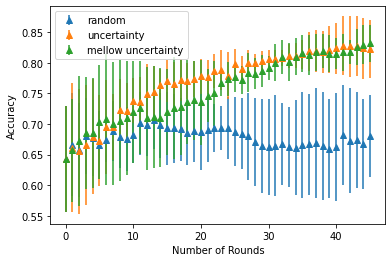

In [930]:
TYPE_ls =  ["random", "uncertainty", "mellow uncertainty"]
simulations(10, classification_data, TYPE_ls)

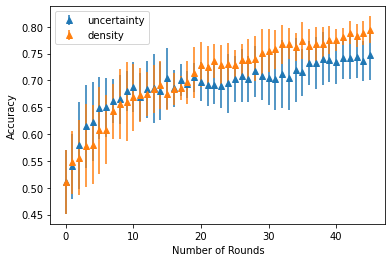

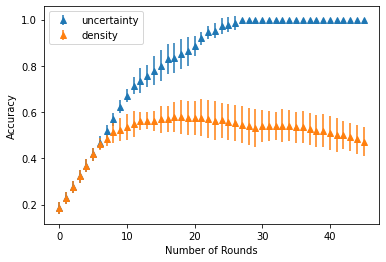

In [1115]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

# even though I assign a psuedorandom seed here, it doesn't seem to affect the generation of the blobs
# weird, doesn't always init 5 points that log reg likes, but when it does it generally produces a similar pattern
# -- verified through many, many trials
def make_datasets():
    SEED = 6
    random.seed(SEED)
    # std = 15 loooks good
    X, y = make_blobs(n_samples=100, n_features=20, centers=3, cluster_std=15)
    y = np.reshape(y, (100, 1))
    data = np.hstack((X, y))
    TYPE_ls = ["uncertainty", "density"]
    simulations(10, data, TYPE_ls)
    plt.close()
    X, y = make_blobs(n_samples=100, n_features=20, centers=20)
    y = np.reshape(y, (100, 1))
    data = np.hstack((X, y))
    simulations(10, data, TYPE_ls)
    
make_datasets()

3A) Generate dataset where uncertainty sampling performs better than density, describe in a few sentences how you generated your data.

I used make_blobs() from sklearn, giving the data structure with 3 centers for the 20 features. I assigned a variance of 15 for each blob, as this seemed to be right around a narrow range where density could consistently beat uncertainty (12-15 std).

3B) Generate dataset where density sampling performs better than uncertainty, describe in a few sentences how you generated your data.

I used make_blobs() from sklearn, giving the data structure with 20 centers for the 20 features. I assigned no special variance and left it as default.

3c. Comment on the differences in the datasets and why you think those differences contributed to differences in learning performance.

The first dataset sits in a very small sweet spot I observed with make_blobs(): just enough centers for the two methods to perform similarly, with just enough variance for density to benefit from the structure without the structure being too easy. If I input only 3 clusters with low (default) variance, the task is trivial and either method converges to perfection essientially instantly. If I input too much std, the blobs are pretty much just pure noise and the two methods perform pretty much the same (i.e. not very well). There is just enough structure for density's awareness to help it, without it being too easy that uncertainty figures it out at the same time. 

The second dataset was much easier to produce, I simply put in a ton of centers to makeblobs() without additional classes. Because the dataset is still a binary classification problem, all the additional structure seems to distract density without harming uncertainty. You can actually increase the number of centers even more and density will do even worse. The key here really was to just overwhelm density with counterproductive structure in the data to force the in-built similarity function to work against it. 

